# Imports

In [2]:
import numpy as np
import pandas as pd

In [3]:
# Mount gdrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load data

In [4]:
# import libraries

import os
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
import collections, random, re
from collections import Counter
from PIL import Image
import glob
from sklearn.model_selection import train_test_split

#model building
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.translate.bleu_score import sentence_bleu
import tensorflow as tf

from keras.layers import LSTM
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from tqdm import tqdm


from tensorflow import keras
from keras.preprocessing import image, sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Defining paths to images, captions and the output directory
CAPTIONS_FILE = '/content/drive/My Drive/data/captions.txt'
OUTPUT_IMAGE_PATH = '/content/drive/My Drive/data/output/'
IMAGE_PATH = '/content/drive/My Drive/data/Images/'

# Images path
images='/content/drive/My Drive/data/Images/'
all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs))) # Check length

The total images present in the dataset: 8091


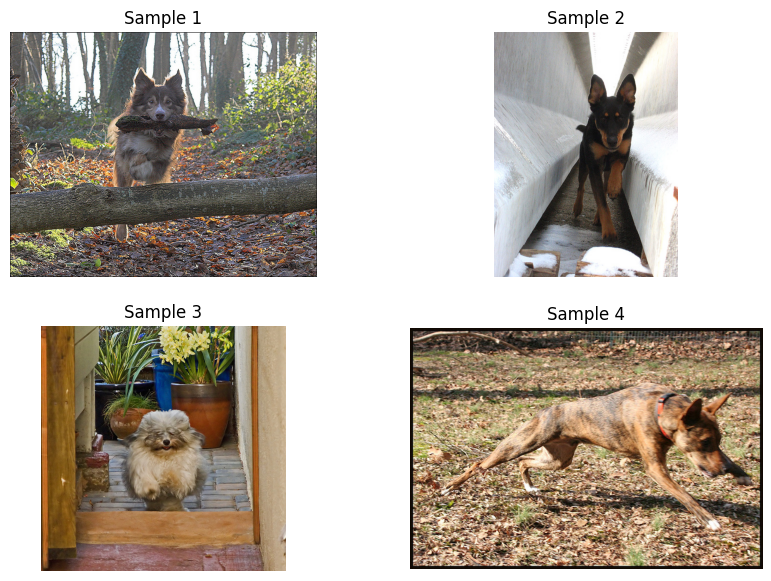

In [6]:
#Visualise a image in the dataset

# create figure
fig = plt.figure(figsize=(10, 7))

# setting values to rows and column variables
rows = 2
columns = 2

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(mpimg.imread(all_imgs[0]))
plt.axis('off')
plt.title("Sample 1")

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)

# showing image
plt.imshow(mpimg.imread(all_imgs[1]))
plt.axis('off')
plt.title("Sample 2")

# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)

# showing image
plt.imshow(mpimg.imread(all_imgs[2]))
plt.axis('off')
plt.title("Sample 3")

# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)

# showing image
plt.imshow(mpimg.imread(all_imgs[3]))
plt.axis('off')
plt.title("Sample 4")

plt.show()

In [7]:
def load_data(filename):
  #Function to load the dataset of image and caption pair

  with open(filename,'r') as fileopen: # iterate over all files
      caption = list(filter(None, (x.rstrip() for x in fileopen))) # Get text/caption

  data = [] # list to keep data
  for x in caption: # sending all captions to data
      data.append(x.split(",",maxsplit=1)) #Maxsplit 1 used to handle the captions with comma

  return data

In [8]:
doc = load_data(CAPTIONS_FILE)
doc[:30] # Check loaded data

[['image', 'caption'],
 ['1000268201_693b08cb0e.jpg',
  'A child in a pink dress is climbing up a set of stairs in an entry way .'],
 ['1000268201_693b08cb0e.jpg', 'A girl going into a wooden building .'],
 ['1000268201_693b08cb0e.jpg',
  'A little girl climbing into a wooden playhouse .'],
 ['1000268201_693b08cb0e.jpg',
  'A little girl climbing the stairs to her playhouse .'],
 ['1000268201_693b08cb0e.jpg',
  'A little girl in a pink dress going into a wooden cabin .'],
 ['1001773457_577c3a7d70.jpg', 'A black dog and a spotted dog are fighting'],
 ['1001773457_577c3a7d70.jpg',
  'A black dog and a tri-colored dog playing with each other on the road .'],
 ['1001773457_577c3a7d70.jpg',
  'A black dog and a white dog with brown spots are staring at each other in the street .'],
 ['1001773457_577c3a7d70.jpg',
  'Two dogs of different breeds looking at each other on the road .'],
 ['1001773457_577c3a7d70.jpg',
  'Two dogs on pavement moving toward each other .'],
 ['1002674143_1b742ab4b8.

# Data Preprocessing

In [84]:
# Create pandas dataframe using data
# DF = ID, Path, Captions

# Lists to store data
id_of_all_images = []
vector_of_all_images = []
annotations_of_all_images = []


for i in doc[1:]:
  id_of_all_images.append(i[0]) # Store image ids
  vector_of_all_images.append(IMAGE_PATH+i[0]) # Store iamges paths
  annotations_of_all_images.append(i[1]) # Store image annotations

df= pd.DataFrame(zip(id_of_all_images, vector_of_all_images, annotations_of_all_images), columns=['ID', 'Path', 'Captions']) # create df
df.head() # check df

ID  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                                Path  \
0  /content/drive/My Drive/data/Images/1000268201...   
1  /content/drive/My Drive/data/Images/1000268201...   
2  /content/drive/My Drive/data/Images/1000268201...   
3  /content/drive/My Drive/data/Images/1000268201...   
4  /content/drive/My Drive/data/Images/1000268201...   

                                            Captions  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        40455 non-null  object
 1   Path      40455 non-null  object
 2   Captions  40455 non-null  object
dtypes: object(3)
memory usage: 948.3+ KB


In [86]:
def plot_image_captions(Pathlist,captionsList,fig,count=2,npix=299,nimg=2):
        image_load = load_img(Path,target_size=(npix,npix,3))
        ax = fig.add_subplot(nimg,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)

        count +=1
        ax = fig.add_subplot(nimg,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(captions))
        for i, caption in enumerate(captions):
            ax.text(0,i,caption,fontsize=20)

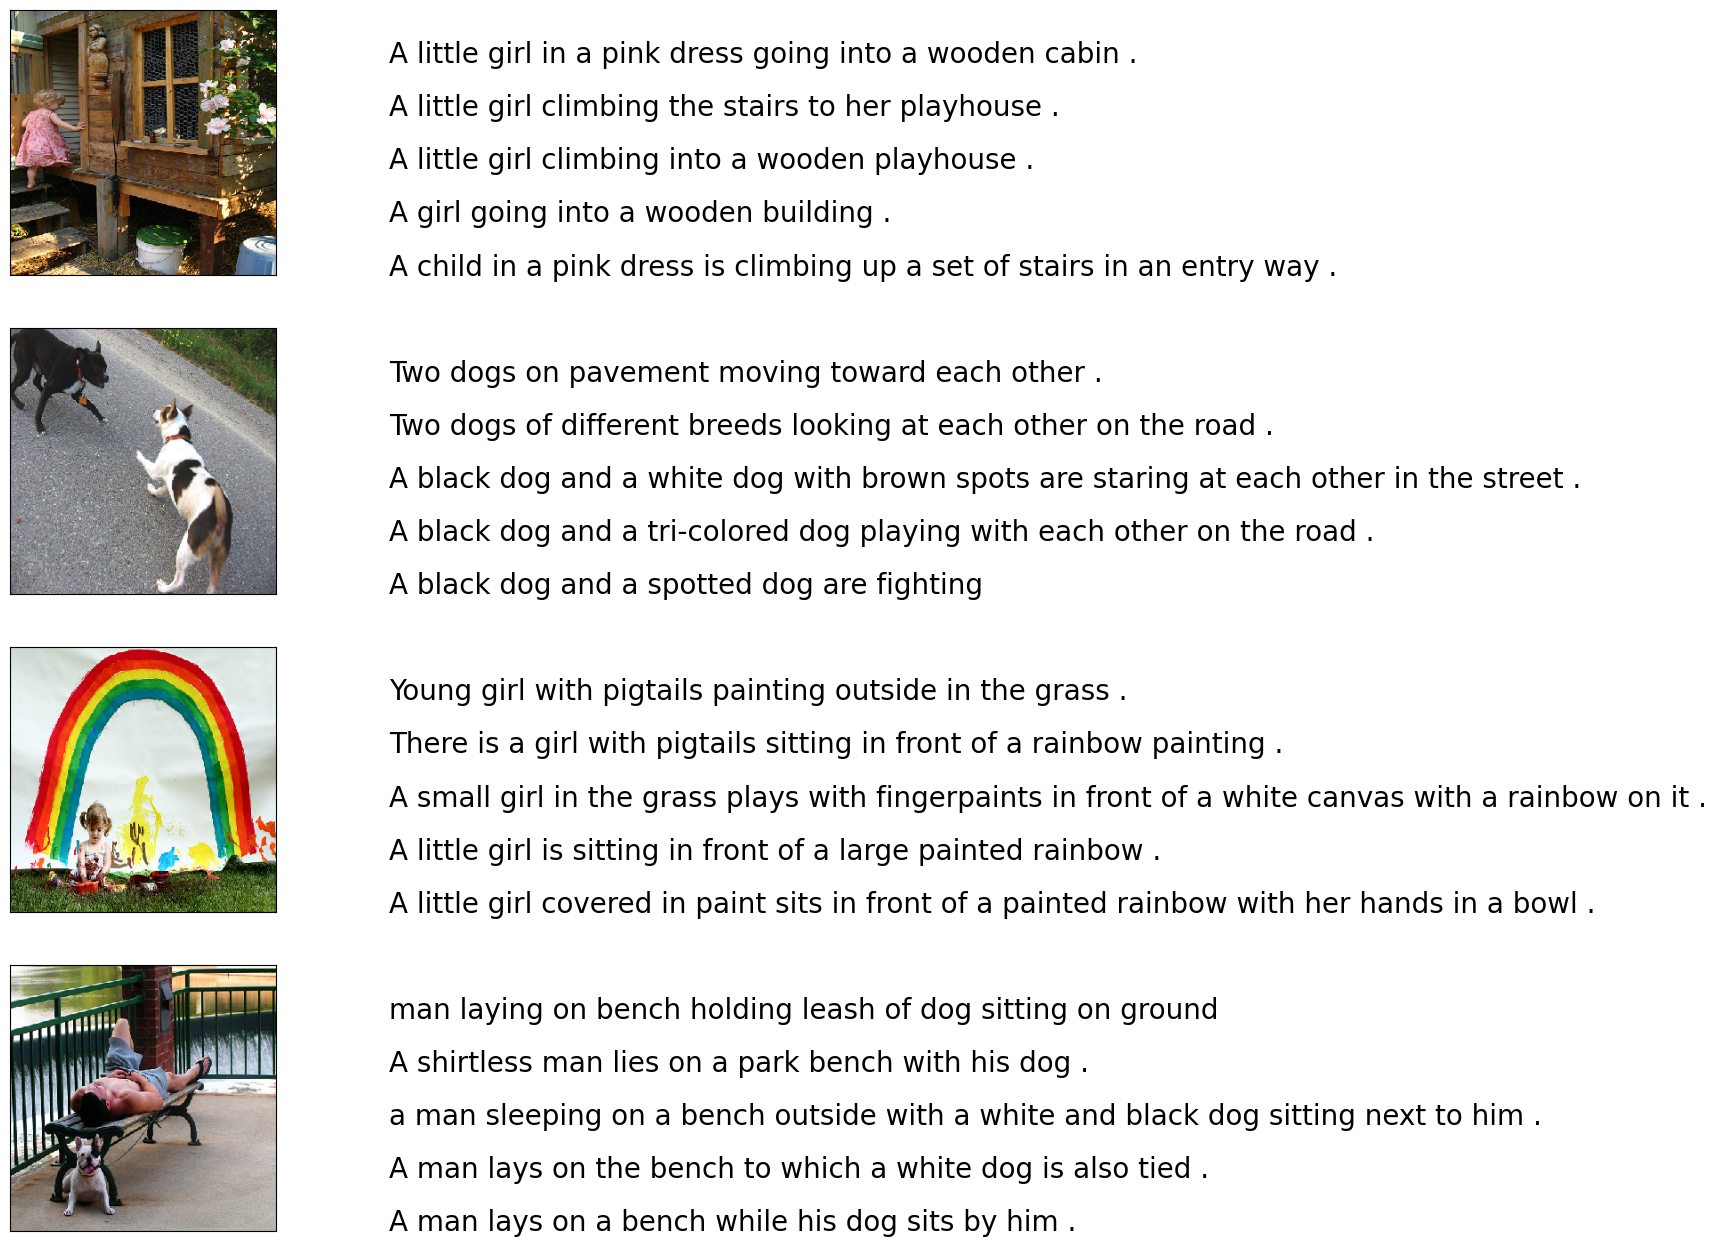

In [87]:
# Images
fig = plt.figure(figsize=(10,20))
count = 1

for Path in df[:20].Path.unique():
    captions = list(df["Captions"].loc[df.Path== Path].values)
    plot_image_captions(Path,captions,fig,count,299,5)
    count +=2
plt.show()

In [88]:
# get the vocabulary from the captions
all_words = []
for caption in df.Captions.values: # iterate through captions
    all_words.extend(caption.split()) # add to list

freq_counter = Counter(all_words) # Get freq of all words
print("Size of Vocab : ",len(set(all_words))) # check number of words

Size of Vocab :  9862


In [89]:
freq_counter.most_common(30) # Check freq of all words

[('a', 40271),
 ('.', 34212),
 ('A', 21481),
 ('in', 18961),
 ('the', 15328),
 ('on', 10729),
 ('is', 9345),
 ('and', 8850),
 ('dog', 7982),
 ('with', 7760),
 ('man', 6828),
 ('of', 6712),
 ('Two', 3962),
 ('white', 3875),
 ('black', 3696),
 ('are', 3503),
 ('boy', 3442),
 ('woman', 3227),
 ('girl', 3217),
 (',', 3210),
 ('to', 3173),
 ('wearing', 3061),
 ('The', 2920),
 ('at', 2904),
 ('water', 2774),
 ('red', 2660),
 ('brown', 2475),
 ('people', 2442),
 ('young', 2431),
 ('."', 2365)]

In [90]:
# Get paths to all images
all_img_path=df.Path.to_list() # Save all image paths in a list

# List to hold annots
annotations = []

# Add start and end tags to sandwich captions
for caption in df.Captions: # Iterate through the captions
    caption1 = '<start>' + ' '
    caption1 +=  caption
    caption1 +=  ' ' + '<end>' # Add start and end tokens
    annotations.append(caption1) # Add annots to the list


# Check lenght of data
print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [91]:
stopwords.words('english') # Check all the stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [92]:
sorted_list = freq_counter.most_common(30) # Get the most frequent 30 words

In [97]:
#Tokenizer object borrowed from tf.keras
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=5000,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

In [100]:
tokenizer.fit_on_texts(annotations) # Fit the tokenizer on our words
train_seqs = tokenizer.texts_to_sequences(annotations) # Get texts of seq for training
print(train_seqs[:5])
print(annotations[:5])

[[3, 2, 44, 5, 2, 91, 173, 8, 120, 52, 2, 394, 13, 395, 5, 29, 1, 671, 4], [3, 2, 20, 317, 65, 2, 197, 118, 4], [3, 2, 41, 20, 120, 65, 2, 197, 2438, 4], [3, 2, 41, 20, 120, 6, 395, 21, 61, 2438, 4], [3, 2, 41, 20, 5, 2, 91, 173, 317, 65, 2, 197, 2982, 4]]
['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>', '<start> A girl going into a wooden building . <end>', '<start> A little girl climbing into a wooden playhouse . <end>', '<start> A little girl climbing the stairs to her playhouse . <end>', '<start> A little girl in a pink dress going into a wooden cabin . <end>']


In [101]:
# printing token
tokenizer.oov_token

'<unk>'

In [102]:
train_seqs[:5]

[[3, 2, 44, 5, 2, 91, 173, 8, 120, 52, 2, 394, 13, 395, 5, 29, 1, 671, 4],
 [3, 2, 20, 317, 65, 2, 197, 118, 4],
 [3, 2, 41, 20, 120, 65, 2, 197, 2438, 4],
 [3, 2, 41, 20, 120, 6, 395, 21, 61, 2438, 4],
 [3, 2, 41, 20, 5, 2, 91, 173, 317, 65, 2, 197, 2982, 4]]

In [103]:
annotations[:5]

['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>',
 '<start> A girl going into a wooden building . <end>',
 '<start> A little girl climbing into a wooden playhouse . <end>',
 '<start> A little girl climbing the stairs to her playhouse . <end>',
 '<start> A little girl in a pink dress going into a wooden cabin . <end>']

In [104]:
# Create word-to-index and index-to-word mappings.

word_index = tokenizer.word_index
index_word = tokenizer.index_word

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Encode training data sentences into sequences
train_seqs  = tokenizer.texts_to_sequences(annotations)

In [105]:
# Encode training data sentences into sequences
train_seqs  = tokenizer.texts_to_sequences(annotations)

In [106]:
print(train_seqs[1]) # Printing the cpation and its tokenized version
print(annotations[1])

[3, 2, 20, 317, 65, 2, 197, 118, 4]
<start> A girl going into a wooden building . <end>


Text(0.5, 1.0, 'Top 30 occurinng words')

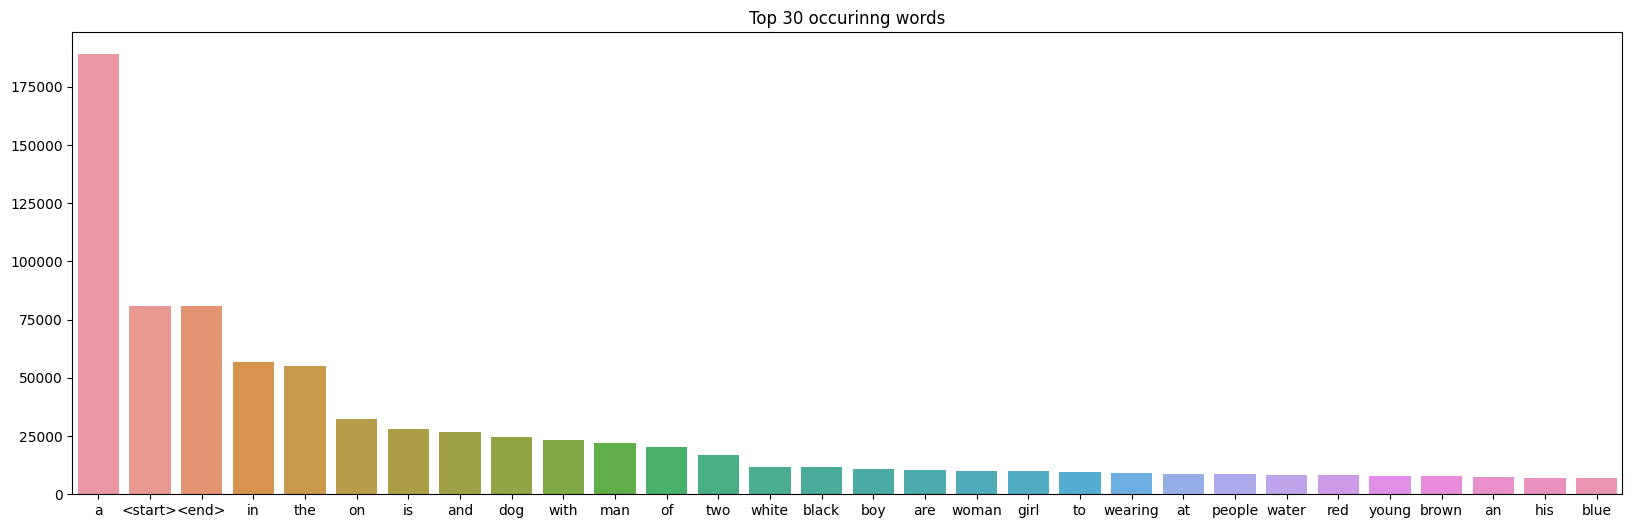

In [107]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing

sort_word_by_count = sorted(tokenizer.word_counts.items(), key=lambda kv : kv[1], reverse= True)
wordCountList = sort_word_by_count[:30]
words,freq = [],[] # Create list to word and freq
for word, count in wordCountList:
    words.append(word) # add word
    freq.append(count) # add freq
plt.figure(figsize=(20,6)) # plot
sns.barplot(x = words, y = freq, orient='v').set_title('Top 30 occurinng words')

In [108]:
!pip install wordcloud

In [109]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS

In [110]:
print(sort_word_by_count)

[('a', 188976), ('<start>', 80910), ('<end>', 80910), ('in', 56958), ('the', 55257), ('on', 32235), ('is', 28035), ('and', 26586), ('dog', 24414), ('with', 23295), ('man', 21822), ('of', 20169), ('two', 16926), ('white', 11877), ('black', 11544), ('boy', 10743), ('are', 10512), ('woman', 10206), ('girl', 9984), ('to', 9528), ('wearing', 9186), ('at', 8745), ('people', 8649), ('water', 8370), ('red', 8073), ('young', 7890), ('brown', 7734), ('an', 7296), ('his', 7071), ('blue', 6837), ('dogs', 6375), ('running', 6219), ('through', 6096), ('playing', 6024), ('while', 5904), ('shirt', 5886), ('down', 5529), ('standing', 5361), ('ball', 5349), ('little', 5304), ('grass', 4866), ('snow', 4641), ('child', 4635), ('person', 4626), ('jumping', 4419), ('over', 4245), ('three', 4161), ('front', 4158), ('sitting', 4104), ('holding', 3972), ('up', 3906), ('field', 3849), ('small', 3834), ('by', 3747), ('large', 3708), ('green', 3702), ('one', 3666), ('group', 3654), ('yellow', 3651), ('her', 3534)

In [111]:
#Create the vocabulary & the counter for the captions
#lower() used to ensure same count irrespective of an alphabet's case

vocabulary1 = [word.lower() for line in annotations for word in line.split()]

val_count = Counter(vocabulary1)
val_count

Counter({'<start>': 40455,
         'a': 61752,
         'child': 1535,
         'in': 18965,
         'pink': 735,
         'dress': 347,
         'is': 9345,
         'climbing': 502,
         'up': 1260,
         'set': 108,
         'of': 6712,
         'stairs': 109,
         'an': 2399,
         'entry': 1,
         'way': 50,
         '.': 34212,
         '<end>': 40455,
         'girl': 3320,
         'going': 149,
         'into': 1074,
         'wooden': 284,
         'building': 509,
         'little': 1754,
         'playhouse': 6,
         'the': 18249,
         'to': 3173,
         'her': 1178,
         'cabin': 4,
         'black': 3825,
         'dog': 8126,
         'and': 8851,
         'spotted': 37,
         'are': 3504,
         'fighting': 132,
         'tri-colored': 14,
         'playing': 2008,
         'with': 7761,
         'each': 430,
         'other': 772,
         'on': 10732,
         'road': 388,
         'white': 3935,
         'brown': 2549,
         

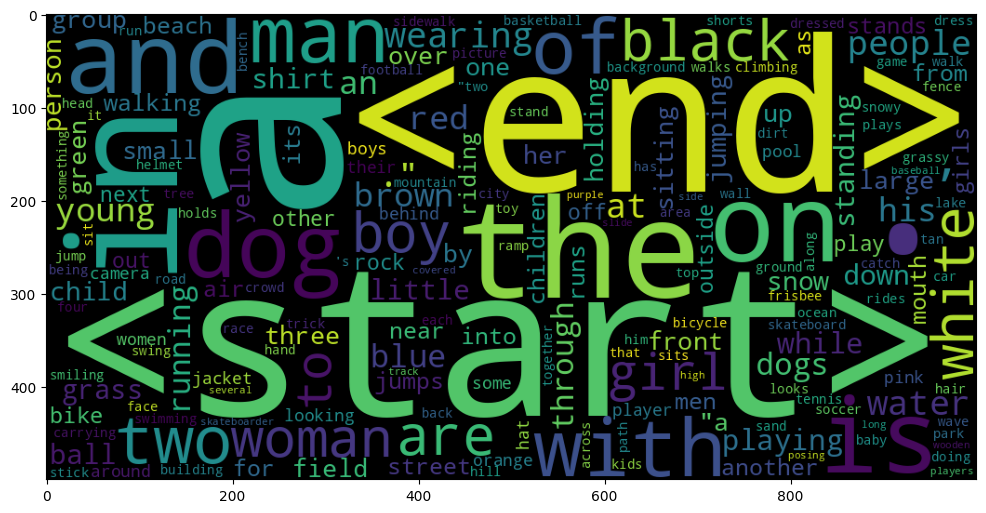

In [112]:
wordcloud_token = WordCloud(width = 1000, height = 500).generate_from_frequencies(Counter(val_count))
plt.figure(figsize = (12, 12))
plt.imshow(wordcloud_token)

In [113]:
# Pad each vector to the max_length of the captions ^ store it to a vairable
# Get max length of caption in our dataset

max_length = 0
for t in train_seqs:
  max_length = max(max_length, len(t))

print("The maximum length of a sentence in the annotation dataset is: " + str(max_length))

caption_vector = keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post', maxlen=max_length) # get the caption vector
print("The shape of Caption vector is :" + str(caption_vector.shape)) # Check dimensions of caption vector

The maximum length of a sentence in the annotation dataset is: 39
The shape of Caption vector is :(40455, 39)


In [114]:
caption_vector # Check caption vector

array([[ 3,  2, 44, ...,  0,  0,  0],
       [ 3,  2, 20, ...,  0,  0,  0],
       [ 3,  2, 41, ...,  0,  0,  0],
       ...,
       [ 3,  2, 45, ...,  0,  0,  0],
       [ 3,  2, 86, ...,  0,  0,  0],
       [ 3,  2, 86, ...,  0,  0,  0]], dtype=int32)

In [115]:
print(caption_vector[0])
print(annotations[0])

[  3   2  44   5   2  91 173   8 120  52   2 394  13 395   5  29   1 671
   4   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]
<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>


In [116]:
# write your code here for creating the function. This function should return images & their path
# We will use tensorflow to resize
def load_image(image_path):
    image = tf.io.read_file(image_path) # Read image from path
    image = tf.image.decode_jpeg(image, channels=3) # read jpeg format
    image = tf.image.resize(image, (299, 299)) # Resize for ease of computation
    image = tf.keras.applications.inception_v3.preprocess_input(image) # Preprocess using earlier inceptionv3 model

    return image, image_path

Path - /content/drive/My Drive/data/Images/1003163366_44323f5815.jpg
Shape after resize : (299, 299, 3)


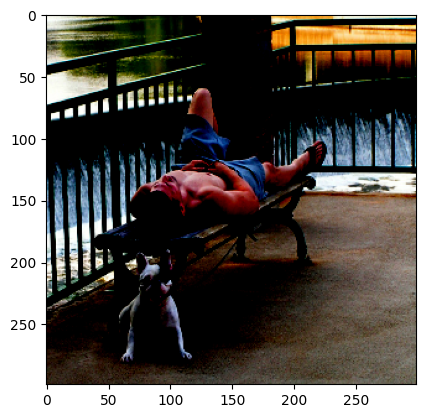

In [117]:
#Load function test
print("Path -",(vector_of_all_images[18]))
print("Shape after resize :", load_image(vector_of_all_images[18])[0].shape)
plt.imshow(load_image(vector_of_all_images[18])[0])

In [118]:
#write your code here for applying the function to the image path dataset, such that the transformed dataset should contain images & their path
#Get unique images
unique_list = sorted(set(vector_of_all_images)) # Get all unique images' vectors

image_dataset = tf.data.Dataset.from_tensor_slices(unique_list).map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64) # Create dataset from unique images

print("Unique number of Images:", len(unique_list))

Unique number of Images: 8091


In [119]:
sample_img_batch, sample_cap_batch = next(iter(image_dataset))
print(sample_img_batch.shape) #(batch_size, 299, 299, 3)
print(sample_cap_batch.shape) #(batch_size, max_len)

(64, 299, 299, 3)
(64,)


# Model

### InceptionV3

In [120]:
#Importing inceptionv3 model from keras with imagenet weights
inceptionv3 = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
# Removing last output layer as we don;t require it here

In [121]:
model_input = inceptionv3.input # Taking input layer of model
final_layer = inceptionv3.layers[-1].output # Taking final layer as output layer for our model
feature_inceptionv3_model = tf.keras.Model(model_input, final_layer) # Getting the weights

In [122]:
feature_inceptionv3_model.summary() # Printing model summary

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, None, None, 32)       864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, None, None, 32)       96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, None, None, 32)       0         ['batch_normalization_94

### Feature extraction and data prep

In [58]:
# code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)


from tqdm import tqdm # To add progress bar

for img, path in tqdm(image_dataset): # Dataset will be having image and path
    batch_features = feature_inceptionv3_model(img) # Applying model on img
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3])) # Reshaping batch features to required size

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")

        path_of_feature1 = os.path.basename(path_of_feature)
        path_of_feature2 = './'+path_of_feature1
        np.save(path_of_feature2, bf.numpy())

100%|██████████| 127/127 [28:21<00:00, 13.39s/it]


In [42]:
!cp /content/1001773457_577c3a7d70.jpg.npy /content/drive/MyDrive/np_files/1.jpg.npy

In [53]:
for filename in os.listdir('/content/'):
    if filename.endswith("jpg.npy"):
        # Your code comes here such as
        print(filename)
        name = '/content/' + filename

        loc = '/content/drive/MyDrive/np_files/' + filename
        !cp {name} {loc}
        break

2218743570_9d6614c51c.jpg.npy


In [123]:
# train test split of 80:20
path_train, path_test, caption_train, caption_test = train_test_split(vector_of_all_images,caption_vector,test_size=0.2,random_state=42)

In [124]:
# Printing length of train and test splits

print("Number of training images: " + str(len(path_train)))
print("Number of testing images: " + str(len(path_test)))
print("Number of Training captions: " + str(len(caption_train)))
print("Number of testing captions: " + str(len(caption_test)))

Number of training images: 32364
Number of testing images: 8091
Number of Training captions: 32364
Number of testing captions: 8091


[ 3  6 16  9 15 10  8 33  7  6 42  4  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
<start> the black and white dog is running on the grass <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


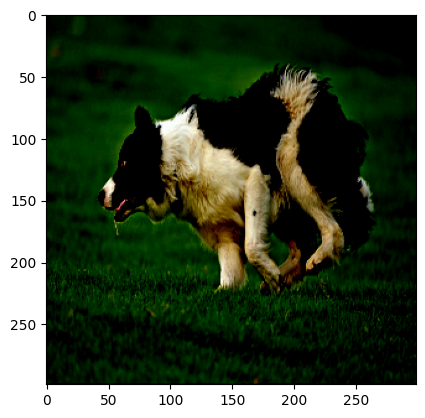

In [125]:
# Visualizing the image and caption from data

print(caption_test[18])
print(" ".join(tokenizer.index_word[i] for i in caption_test[18]))
plt.imshow(load_image(path_test[18])[0])

In [126]:
# function to map image with its features
# Image path and its caption are input
def map_image_to_feature(image, caption):
    # Finding base name of image
    base_name = os.path.basename(image.numpy().decode('utf-8'))

    # full name is created by appending base name with './'
    input_image_name = './' + base_name

    # Loading the tensor of features using saved numpy file
    image_tensor = np.load(input_image_name + '.npy')

    # returning tensor of img and its caption
    return image_tensor, caption


In [127]:
# function to make data appropriate for model
# transform the img to features

def data_prep(image,caption, batch_size=32, buffer_size=1000):

    dataset = tf.data.Dataset.from_tensor_slices((image, caption)) # Doing word masking

    # Use map to load the numpy files in parallel
    dataset = dataset.map(lambda item1, item2: tf.py_function(map_image_to_feature, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size) # Shuffling the dataset
    dataset = dataset.batch(batch_size) # Making batch of data
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE) # Prefetch next batch of data for faster training

    return dataset

In [128]:
train_dataset = data_prep(path_train,caption_train,64) # Train data with batch size 64
test_dataset = data_prep(path_test,caption_test,64) # Test data with batch size 64

In [129]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape) #(batch_size, 299, 299, 3)
print(sample_cap_batch.shape) #(batch_size, max_len)

(64, 64, 2048)
(64, 39)


In [65]:
for img, path in tqdm(image_dataset): # Dataset will be having image and path
    batch_features = feature_inceptionv3_model(img) # Applying model on img
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3])) # Reshaping batch features to required size

    for bf, p in zip(batch_features, path):
      break

100%|██████████| 127/127 [01:21<00:00,  1.55it/s]


In [130]:
BATCH_SIZE = 32 # Batch size
embedding_dim = 256 # Embedding dimension from keras embedding library
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(path_train) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = bf.shape[1]
attention_features_shape = bf.shape[0]

In [155]:
# Reference: https://www.kaggle.com/code/tripsankur/eye-for-blind-image-to-text

class Encoder(Model): # Encoder model with inceptionv3
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim)

    def call(self, features):
        # extract the features from the image shape: (batch, 8*8, embed_dim)
        features =  self.dense(features) # Adding one extra dense and relu layer to adjust inceptionv3 output to our required size
        features = tf.keras.activations.relu(features, alpha=0.01, max_value=None, threshold=0)

        return features

### Encoder, Decoder and Attention models

In [156]:
# Reference: https://www.kaggle.com/code/tripsankur/eye-for-blind-image-to-text

class Attention_model(Model): #Attention model
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units) #build your Dense layer
        self.V = tf.keras.layers.Dense(1) #build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1) # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        score = tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis)) # build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights =  tf.keras.activations.softmax(self.V(score), axis=1) # extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector = attention_weights * features #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis = 1) # reduce the shape to (batch_size, embedding_dim)


        return context_vector, attention_weights

In [157]:
# Reference: https://www.kaggle.com/code/tripsankur/eye-for-blind-image-to-text

class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units) #iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim) # Embedding layer using keras
        self.gru = tf.keras.layers.GRU(self.units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform') # GRU layer
        self.d1 = tf.keras.layers.Dense(self.units) # Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size) # Dense layer
        # self.dropout = tf.keras.layers.Dropout(0.5) # Dropouts


    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        # embed =  self.dropout(self.embed(x))# embed your input to shape: (batch_size, 1, embedding_dim)
        embed = self.embed(x)
        # mask = self.embed.compute_mask(x)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)

        return output,state, attention_weights

    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [158]:
encoder=Encoder(embedding_dim)  # Encoder instance

In [159]:
decoder=Decoder(embedding_dim, units, vocab_size) # Decoder instance

In [160]:
features=encoder(sample_img_batch) # getting features using encoder

In [161]:
hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0]) #initializing hidden state to zeros
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)

In [162]:
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


### Loss functions and training prep

In [163]:
optimizer = tf.keras.optimizers.Adam() #define the optimizer

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none') #define your loss object

In [164]:
def loss_cal(real, pred): # Loss function takes real and pred as input
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    # This mask is excludes padding tokens (denoted by 0) from contributing to the loss.
    loss_ = loss_object(real, pred)
    # Appying BCE loss on real and pred
    mask = tf.cast(mask, dtype=loss_.dtype)
    # Matching data taype of mask and loss_
    loss_ *= mask
    # Multiplying loss with mask to remove effect of those padding tokens in loss

    return tf.reduce_mean(loss_) # Reducing the tensor to single scalar value as loss

In [165]:
checkpoint_path = "./checkpoints/train" # Creating checkpoint for saving model at intermidiate points
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [166]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [167]:
@tf.function # converting python function to tf graph to optimize

def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1) # giving batch size vector having start token as deocder input

    with tf.GradientTape() as tape:

        features = encoder(img_tensor)
        # Extracting features using encoder model
        for i in range(1, target.shape[1]): # Loop on entire sentence
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden) # prediction given by decoder
            loss += loss_cal(target[:, i], predictions) # Passing pred to loss function

            dec_input = tf.expand_dims(target[:, i], 1) # Giving pred back to decoder for next iteration
        avg_loss = (loss/int(target.shape[1])) # averaging loss across sentence size
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        # trainable variables of decoder and encoder
        gradients = tape.gradient(loss, trainable_variables) # gradient with respect to trainable variables only
        optimizer.apply_gradients(zip(gradients, trainable_variables)) # Giving gradients back to optimizer to update model

    return loss, avg_loss

In [168]:
# Define Test/Validation Step that does not use Teacher Forcing
#Adding this to fetch numpy from TF
#tf.config.run_functions_eagerly(True)

@tf.function
def test_step(img_tensor, target): # Similar code as train loop
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_cal(target[:, i], predictions)

            predicted_id = tf.argmax(predictions,1) # Taking argmax to find the next most probable word

            dec_input = tf.expand_dims(predicted_id, 1) # This word will go again in decoder input

        avg_loss = (loss / int(target.shape[1])) # Avearging loss across sentence size

    return loss, avg_loss

In [169]:
def test_loss_function(test_dataset): # Averaging test loss over all steps
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
    avg_test_loss=total_loss/test_num_steps

    return avg_test_loss

In [170]:
import gc

In [ ]:
del df
del caption_vector


In [172]:
gc.collect()

1118972

### Training

In [173]:
# Model Training using train step function defined above
best_test_loss=100

loss_plot = []
test_loss_plot = []
EPOCHS = 15


for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])

    loss_plot.append(avg_train_loss) # for plotting
    test_loss = test_loss_function(test_dataset)
    test_loss_plot.append(test_loss) # for plotting

    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

    if test_loss < best_test_loss: # saving models when test loss starts diverging
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 0.631, & test loss is 0.953
Time taken for 1 epoch 407.07928681373596 sec

Test loss has been reduced from 100.000 to 0.953


  7%|▋         | 1/15 [06:47<1:35:06, 407.60s/it]

For epoch: 2, the train loss is 0.490, & test loss is 0.945
Time taken for 1 epoch 232.32026600837708 sec

Test loss has been reduced from 0.953 to 0.945


 20%|██        | 3/15 [14:32<54:17, 271.46s/it]  

For epoch: 3, the train loss is 0.447, & test loss is 0.948
Time taken for 1 epoch 231.76298904418945 sec



 27%|██▋       | 4/15 [18:16<46:22, 253.00s/it]

For epoch: 4, the train loss is 0.415, & test loss is 0.997
Time taken for 1 epoch 224.67096328735352 sec



 33%|███▎      | 5/15 [22:09<40:55, 245.56s/it]

For epoch: 5, the train loss is 0.389, & test loss is 0.986
Time taken for 1 epoch 232.36010575294495 sec



 40%|████      | 6/15 [26:18<37:00, 246.78s/it]

For epoch: 6, the train loss is 0.366, & test loss is 0.982
Time taken for 1 epoch 249.11096501350403 sec



 47%|████▋     | 7/15 [35:53<47:13, 354.14s/it]

For epoch: 7, the train loss is 0.345, & test loss is 1.001
Time taken for 1 epoch 575.1557943820953 sec



 53%|█████▎    | 8/15 [40:00<37:19, 319.99s/it]

For epoch: 8, the train loss is 0.325, & test loss is 1.028
Time taken for 1 epoch 246.83127331733704 sec



 60%|██████    | 9/15 [43:58<29:26, 294.44s/it]

For epoch: 9, the train loss is 0.306, & test loss is 1.052
Time taken for 1 epoch 238.23747158050537 sec



 67%|██████▋   | 10/15 [47:45<22:47, 273.54s/it]

For epoch: 10, the train loss is 0.289, & test loss is 1.097
Time taken for 1 epoch 226.73269319534302 sec



 73%|███████▎  | 11/15 [51:44<17:32, 263.08s/it]

For epoch: 11, the train loss is 0.273, & test loss is 1.131
Time taken for 1 epoch 239.35394167900085 sec



 80%|████████  | 12/15 [58:44<15:32, 310.79s/it]

For epoch: 12, the train loss is 0.258, & test loss is 1.166
Time taken for 1 epoch 419.88806343078613 sec



 87%|████████▋ | 13/15 [1:02:12<09:19, 279.62s/it]

For epoch: 13, the train loss is 0.244, & test loss is 1.230
Time taken for 1 epoch 207.88258337974548 sec



 93%|█████████▎| 14/15 [1:05:26<04:13, 253.71s/it]

For epoch: 14, the train loss is 0.230, & test loss is 1.246
Time taken for 1 epoch 193.81785368919373 sec



100%|██████████| 15/15 [1:08:59<00:00, 275.96s/it]

For epoch: 15, the train loss is 0.218, & test loss is 1.292
Time taken for 1 epoch 212.82790756225586 sec



In [174]:
gc.collect()

1089

### Loss plot

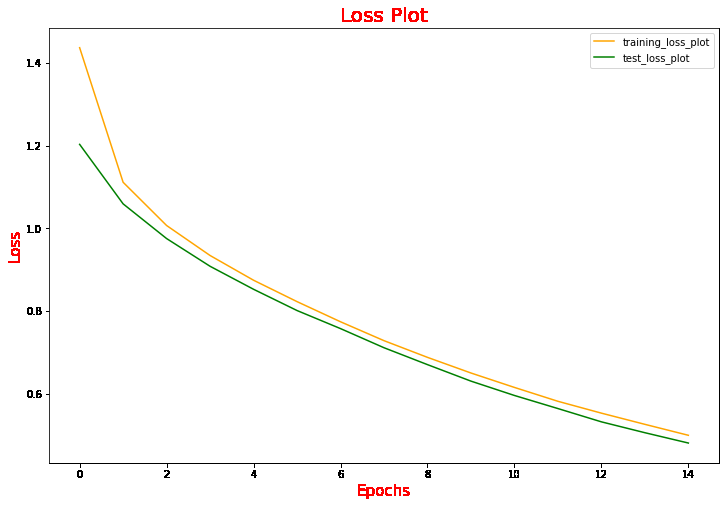

In [201]:
from matplotlib.pyplot import figure
figure(figsize=(12, 8))
plt.plot(loss_plot, color='orange', label = 'training_loss_plot')
plt.plot(test_loss_plot, color='green', label = 'test_loss_plot')
plt.xlabel('Epochs', fontsize = 15, color = 'red')
plt.ylabel('Loss', fontsize = 15, color = 'red')
plt.title('Loss Plot', fontsize = 20, color = 'red')
plt.legend()
plt.show()

### Greedy Search

In [176]:
# Greedy way to choose next word at each step

def greedy_evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape)) # initialize

    hidden = decoder.init_state(batch_size=1) # initialize hidden layer

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = feature_inceptionv3_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val) # getting features from encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 1) # start token as decoder input
    print("dec_input Shape", dec_input.shape)
    result = []

    for i in range(max_length): # Going till max length of sentence which is 39 here
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy() # attention weights to plot attention

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()

        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions # end if <end> token is most probable according to model

        dec_input = tf.expand_dims([predicted_id], 0) # giving pred to decoder again for next word

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot, predictions

### Beam Search

In [177]:
# Using Beam Search with beam width of 3

def beam_evaluate(image, beam_index = 3):
    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = feature_inceptionv3_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < max_length:
        i=0
        temp = []
        for s in result:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            i=i+1
            word_preds = np.argsort(predictions[0])[-beam_index:] # taking top 3 predictions

            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)

                prob += np.log(predictions[0][w]) # Adding log of prob instead of direct multiplying to avoid underflow

                temp.append([next_cap, prob])
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:] # Only take top 3 result sequences and discard else


        predicted_id = result[-1]
        pred_list = predicted_id[0]

        prd_id = pred_list[-1]
        if(prd_id!=3): # checking for end token
            dec_input = tf.expand_dims([prd_id], 0)
        else:
            break


    result2 = result[-1][0]

    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i) # appending word to final caption

        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])
    return final_caption

### Plotting attention map over image

In [178]:
# Plotting different parts of the image which are used for captioning
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image)) # Opening given image

    len_cap = len(caption)
    for cap in range(len_cap): # iterate over all words
        weights_img = np.reshape(weights[cap], (8,8)) # Reshape attention weights to 8 X 8
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS)) #resize again to 224 X 224

        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)

        img=ax.imshow(temp_img) # Showing the original image

        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent()) # Overlaying the attention weights on image
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

### Evaluating on unknown data

In [179]:
from PIL import Image
def Prediction_Unknown_data(test_image):
    #Testing on test image
    openImg = test_image
    print(test_image)

    result, attention_plot,pred_test = greedy_evaluate(test_image)
    pred_caption=' '.join(result).rsplit(' ', 1)[0]

    candidate = pred_caption.split()

    print ('Prediction Caption:', pred_caption)
    print ('')

    im = Image.open(openImg)
    width, height = im.size
    print(width,height)
    div=3
    if width > 3000:
        div=10
    im = im.resize((width//div, height//div))

    return im


/content/drive/My Drive/data/Images/374124237_51f62b6937.jpg
dec_input Shape (1, 1)
Prediction Caption: a blonde woman dressed in the black

500 375


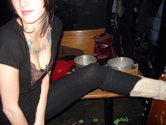

In [181]:
Prediction_Unknown_data(path_test[11])

/content/drive/My Drive/data/Images/270263570_3160f360d3.jpg
dec_input Shape (1, 1)
Prediction Caption: two brown and black and black and white dog is running through the woods

500 461


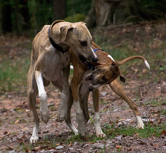

In [184]:
Prediction_Unknown_data(path_test[1])

### Testing the model

In [186]:
from nltk.translate.bleu_score import sentence_bleu

def Testing_Model(img_test):
    #Testing on test image
    rid = np.random.randint(0, len(img_test)) # Taking random test img
    test_image = img_test[rid]

    real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
    result, attention_plot,pred_test = greedy_evaluate(test_image) # Evaluating img


    filt=['<start>','<unk>','<end>'] # Filtering start, unk and end token
    temp= real_caption.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    real_caption=' '.join(temp)



    pred_caption=' '.join(result).rsplit(' ', 1)[0] # Making pred caption from result obtained via evaluate

    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = pred_caption.split()

    print ('Real Caption      :', real_caption)
    print ('Prediction Caption:', pred_caption)
    print ('')
    score1 = sentence_bleu(reference, candidate, weights=(1,0,0,0))
    score2 = sentence_bleu(reference, candidate, weights=(0,1,0,0))
    score3 = sentence_bleu(reference, candidate, weights=(0,0,1,0))
    score4 = sentence_bleu(reference, candidate, weights=(0,0,0,1))

    # Printing BLEU score for all

    print("\nBLEU score: ")
    print(f"Individual 1-gram: {score1*100}")
    print(f"Individual 2-gram: {score2*100}")
    print(f"Individual 3-gram: {score3*100}")
    print(f"Individual 4-gram: {score4*100}")
    plot_attmap(result, attention_plot, test_image)

    return test_image, pred_caption

dec_input Shape (1, 1)
Real Caption      : a dog playing
Prediction Caption: a brown dog walks across the neighborhood


BLEU score: 
Individual 1-gram: 28.57142857142857
Individual 2-gram: 2.2250738585072627e-306
Individual 3-gram: 2.2250738585072627e-306
Individual 4-gram: 2.2250738585072627e-306


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

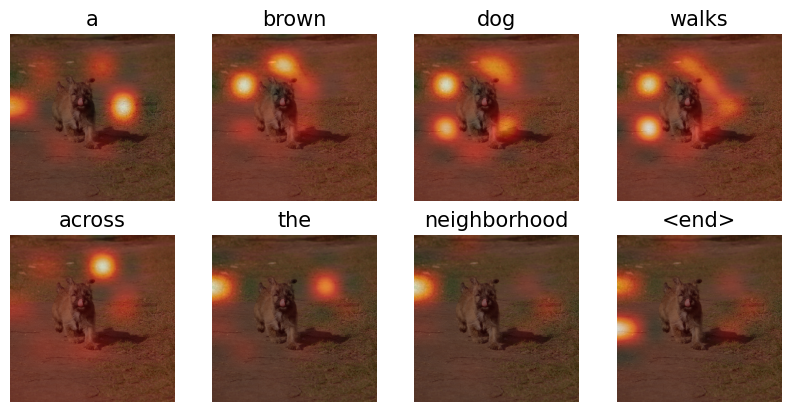

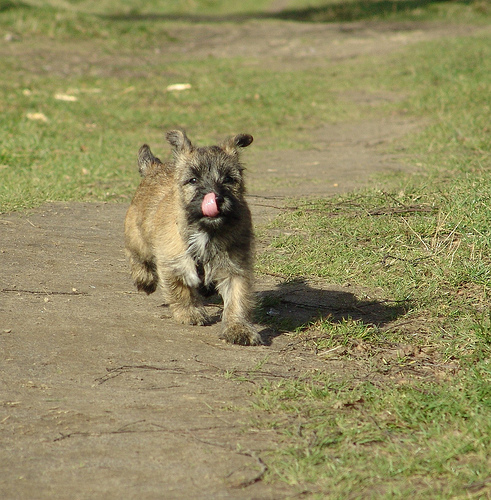

In [187]:
test_image, pred_caption = Testing_Model(path_test)
Image.open(test_image)

dec_input Shape (1, 1)
Real Caption      : a woman standing on a snowy hill about to ski
Prediction Caption: a woman skier in a red jacket and the sun gear on a snowy mountain


BLEU score: 
Individual 1-gram: 33.33333333333333
Individual 2-gram: 21.428571428571423
Individual 3-gram: 7.6923076923076925
Individual 4-gram: 2.2250738585072627e-306


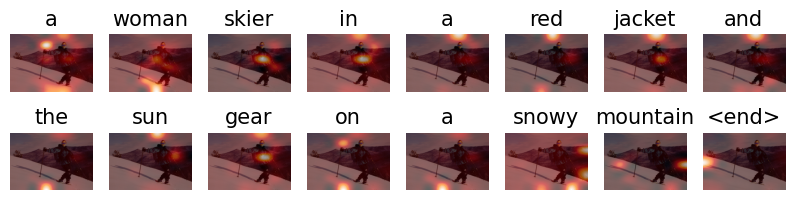

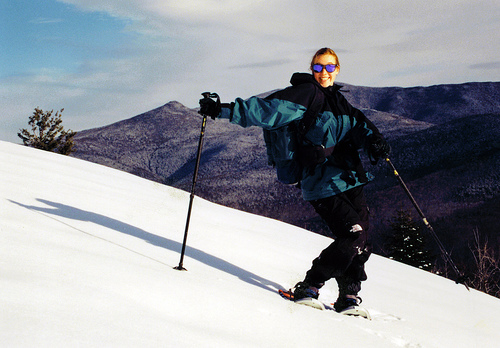

In [188]:
test_image, pred_caption = Testing_Model(path_test)
Image.open(test_image)

In [189]:
beam_caption=beam_evaluate(test_image)
print(beam_caption)

a woman wearing get the snow


#Text to Audio

Using gTTS libraray for text to audio conversion.

In [190]:
pip install gTTS

In [191]:
# imports
from gtts import gTTS
from IPython import display

In [192]:
#Caption to audio conversion
op = 'output.mp3' # Output file

tts = gTTS(pred_caption, slow = False)
tts.save(op) # saving audio caption

display.display(display.Audio(op)) # Displaying play control for audio

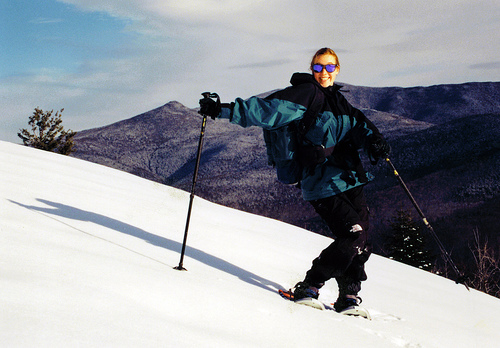

In [193]:
Image.open(test_image)

# Refrences




*   https://www.kaggle.com/code/tripsankur/eye-for-blind-image-to-text
*   https://github.com/jashan20/Vision-For-Blind


*   https://www.kaggle.com/datasets/adityajn105/flickr8k

*   https://sooftware.io/beamsearch/
*   https://sh-tsang.medium.com/review-inception-v3-1st-runner-up-\image-classification-in-ilsvrc-2015-17915421f77c


*   https://tinyurl.com/bdz8e4ny


*   https://www.kaggle.com/code/anushkaml/eye-for-blind-cnn-rnn-attentionmodel/notebook#Model-Building





